<a href="https://colab.research.google.com/github/plaban1981/Deep-Learning-KERAS/blob/master/glaucoma_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


/content/drive/MyDrive/Glaucoma_recognition/


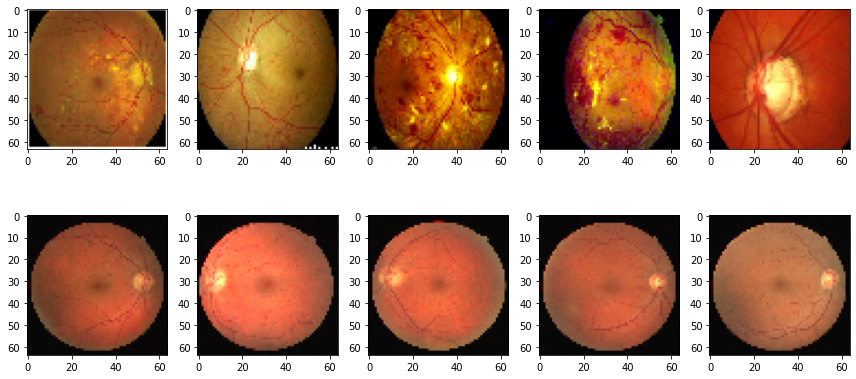

In [2]:
# display some images for every different expression
import os
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 64

# input path for the images
base_path = '/content/drive/MyDrive/Glaucoma_recognition/'
print(base_path)
plt.figure(0, figsize=(12,20))
cpt = 0

for images in os.listdir(base_path + "train"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + images + "/" +os.listdir(base_path + "train/" + images)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)

plt.tight_layout()
plt.show()

# Setup the data generators

Deep learning models are trained by being fed with batches of data. 

#### Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.

Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 16

datagen_train = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
datagen_validation = ImageDataGenerator(rescale = 1./255)

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


# Setup our Convolutional Neural Network (CNN)

#### CNN - is good for extracting the features of images and is widely used for image analysis subjects like image classification.

#### CNN Architechture

* 4 convolutional layers

* 2 fully connected layers


The convolutional layers will extract relevant features from the images 

The fully connected layers will focus on using these features to classify well our images.


* A convolution operator: extracts features from the input image using sliding matrices to preserve the spatial relations between the pixels.

* We apply the ReLU function to introduce non linearity in our CNN. Other functions like tanh or sigmoid could also be used, but ReLU has been found to perform better in most situations.

* Pooling is used to reduce the dimensionality of each features while retaining the most important information.

* Batch normalization: improves the performance and stability of NNs by providing inputs with zero mean and unit variance.
    
* Dropout: reduces overfitting by randomly not updating the weights of some nodes. This helps prevent the NN from relying on one node in the layer too much.
    
* We chose sigmoid as our last activation function as it is commonly used for binary classification.

In [4]:
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# number of possible label values
nb_classes = 2

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(64, 64,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       2

# Train the model

In [6]:
validation_generator.n

20

In [7]:
validation_generator.batch_size

16

In [8]:
validation_generator.n//validation_generator.batch_size

1

# train_generator.n//train_generator.batch_size

In [9]:
# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_generator,
                    #steps_per_epoch=80,
                    epochs=epochs,
                    validation_data = validation_generator,
                    validation_steps = 10,
                    callbacks=callbacks_list)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.7852 - accuracy: 0.6125


Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to model_weights.h5
5/5 [==============================] - 33s 4s/step - loss: 0.7852 - accuracy: 0.6125 - val_loss: 0.6913 - val_accuracy: 0.5500
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.5666 - accuracy: 0.7875

5/5 [==============================] - 1s 250ms/step - loss: 0.5666 - accuracy: 0.7875
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.9000

5/5 [==============================] - 1s 239ms/step - loss: 0.4288 - accuracy: 0.9000
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.9000

5/5 [==============================] - 2s 342ms/step - loss: 0.3403 - accuracy: 0.9000
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.9000

5/5 [==============================] - 1s 246ms/step - loss: 0.3149 - accuracy: 0.9000
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.9375

5/5 [==============================] - 1s 287ms/step - loss: 0.2523 - accuracy: 0.9375
Epoch 7/50
5/5 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9375

5/5 [==============================] - 1s 251ms/step - loss: 0.2233 - accuracy: 0.9375
Epoch 8/50
5/5 [==============================] - ETA: 0s - loss: 0.2106 - accuracy: 0.9625

5/5 [==============================] - 1s 240ms/step - loss: 0.2106 - accuracy: 0.9625
Epoch 9/50
5/5 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9500

5/5 [==============================] - 1s 237ms/step - loss: 0.2018 - accuracy: 0.9500
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9500

5/5 [==============================] - 1s 234ms/step - loss: 0.1696 - accuracy: 0.9500
Epoch 11/50
5/5 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9750

5/5 [==============================] - 1s 225ms/step - loss: 0.1572 - accuracy: 0.9750
Epoch 12/50
5/5 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9875

5/5 [==============================] - 1s 243ms/step - loss: 0.1329 - accuracy: 0.9875
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9750

5/5 [==============================] - 1s 241ms/step - loss: 0.1207 - accuracy: 0.9750
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9250

5/5 [==============================] - 1s 235ms/step - loss: 0.1623 - accuracy: 0.9250
Epoch 15/50
5/5 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9875

5/5 [==============================] - 1s 234ms/step - loss: 0.1309 - accuracy: 0.9875
Epoch 16/50
5/5 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9625

5/5 [==============================] - 1s 238ms/step - loss: 0.1369 - accuracy: 0.9625
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9750

5/5 [==============================] - 1s 254ms/step - loss: 0.0963 - accuracy: 0.9750
Epoch 18/50
5/5 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9875

5/5 [==============================] - 1s 237ms/step - loss: 0.0853 - accuracy: 0.9875
Epoch 19/50
5/5 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9875

5/5 [==============================] - 1s 239ms/step - loss: 0.0878 - accuracy: 0.9875
Epoch 20/50
5/5 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 1.0000

5/5 [==============================] - 1s 244ms/step - loss: 0.0648 - accuracy: 1.0000
Epoch 21/50
5/5 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9750

5/5 [==============================] - 1s 253ms/step - loss: 0.1019 - accuracy: 0.9750
Epoch 22/50
5/5 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9875

5/5 [==============================] - 1s 242ms/step - loss: 0.0899 - accuracy: 0.9875
Epoch 23/50
5/5 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9875

5/5 [==============================] - 1s 236ms/step - loss: 0.0807 - accuracy: 0.9875
Epoch 24/50
5/5 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 1.0000

5/5 [==============================] - 1s 248ms/step - loss: 0.0526 - accuracy: 1.0000
Epoch 25/50
5/5 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9750

5/5 [==============================] - 1s 258ms/step - loss: 0.0823 - accuracy: 0.9750
Epoch 26/50
5/5 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 1.0000

5/5 [==============================] - 1s 241ms/step - loss: 0.0471 - accuracy: 1.0000
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9875

5/5 [==============================] - 1s 233ms/step - loss: 0.0766 - accuracy: 0.9875
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9750

5/5 [==============================] - 1s 241ms/step - loss: 0.0937 - accuracy: 0.9750
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9625

5/5 [==============================] - 1s 241ms/step - loss: 0.1013 - accuracy: 0.9625
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9875

5/5 [==============================] - 1s 235ms/step - loss: 0.0363 - accuracy: 0.9875
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 1.0000

5/5 [==============================] - 1s 233ms/step - loss: 0.0532 - accuracy: 1.0000
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 1.0000

5/5 [==============================] - 1s 236ms/step - loss: 0.0441 - accuracy: 1.0000
Epoch 33/50
5/5 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.9750

5/5 [==============================] - 1s 247ms/step - loss: 0.0801 - accuracy: 0.9750
Epoch 34/50
5/5 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 1.0000

5/5 [==============================] - 1s 245ms/step - loss: 0.0334 - accuracy: 1.0000
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9875

5/5 [==============================] - 1s 244ms/step - loss: 0.0447 - accuracy: 0.9875
Epoch 36/50
5/5 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9875

5/5 [==============================] - 1s 250ms/step - loss: 0.0821 - accuracy: 0.9875
Epoch 37/50
5/5 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 1.0000

5/5 [==============================] - 1s 245ms/step - loss: 0.0463 - accuracy: 1.0000
Epoch 38/50
5/5 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 1.0000

5/5 [==============================] - 1s 227ms/step - loss: 0.0363 - accuracy: 1.0000
Epoch 39/50
5/5 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9875

5/5 [==============================] - 1s 236ms/step - loss: 0.0799 - accuracy: 0.9875
Epoch 40/50
5/5 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9875

5/5 [==============================] - 1s 236ms/step - loss: 0.0556 - accuracy: 0.9875
Epoch 41/50
5/5 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 1.0000

5/5 [==============================] - 1s 226ms/step - loss: 0.0289 - accuracy: 1.0000
Epoch 42/50
5/5 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9750

5/5 [==============================] - 1s 242ms/step - loss: 0.0884 - accuracy: 0.9750
Epoch 43/50
5/5 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 1.0000

5/5 [==============================] - 1s 233ms/step - loss: 0.0421 - accuracy: 1.0000
Epoch 44/50
5/5 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9875

5/5 [==============================] - 1s 240ms/step - loss: 0.0602 - accuracy: 0.9875
Epoch 45/50
5/5 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9875

5/5 [==============================] - 1s 258ms/step - loss: 0.0686 - accuracy: 0.9875
Epoch 46/50
5/5 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9875

5/5 [==============================] - 1s 241ms/step - loss: 0.0350 - accuracy: 0.9875
Epoch 47/50
5/5 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 1.0000

5/5 [==============================] - 1s 246ms/step - loss: 0.0249 - accuracy: 1.0000
Epoch 48/50
5/5 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9875

5/5 [==============================] - 1s 251ms/step - loss: 0.0443 - accuracy: 0.9875
Epoch 49/50
5/5 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9875

5/5 [==============================] - 1s 244ms/step - loss: 0.0324 - accuracy: 0.9875
Epoch 50/50
5/5 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 1.0000

5/5 [==============================] - 1s 231ms/step - loss: 0.0511 - accuracy: 1.0000


In [10]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [11]:
history.history['val_accuracy']

[0.550000011920929]

## Visualizing intermediate activations (Output of each layer)

(1, 64, 64, 3)


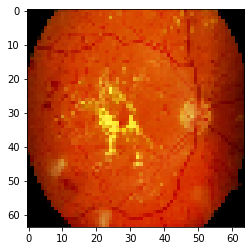

In [12]:
from keras.preprocessing import image
import numpy as np
image_path = "/content/drive/MyDrive/Glaucoma_recognition/validation/Glaucoma/2 (35).jpg"
# Pre-processing the image
img = image.load_img(image_path, target_size = (64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor = img_tensor / 255.

# Print image tensor shape
print(img_tensor.shape)

# Print image
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()


In [16]:
len([layer.output for layer in model.layers])

30

## Using Keras Model class to get outputs of each layer

In [17]:
from keras import models
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

In [18]:
len(activations)

8

In [19]:
activations[0].shape

(1, 64, 64, 64)

(1, 64, 64, 64)


Text(0.5, 1.05, '15th channel of the image after first layer of convolution is applied')

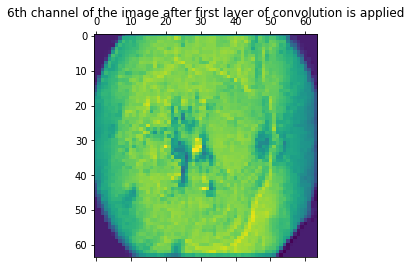

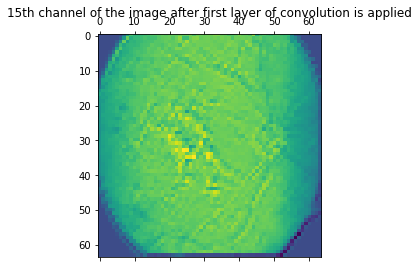

In [20]:
# Getting Activations of first layer
first_layer_activation = activations[0]
  
# shape of first layer activation
print(first_layer_activation.shape)
  
# 6th channel of the image after first layer of convolution is applied
plt.matshow(first_layer_activation[0, :, :, 6], cmap ='viridis')
plt.title("6th channel of the image after first layer of convolution is applied")
  
# 15th channel of the image after first layer of convolution is applied
plt.matshow(first_layer_activation[0, :, :, 15], cmap ='viridis')
plt.title("15th channel of the image after first layer of convolution is applied")

In [23]:
layer_names = []

for layer in model.layers[:8]:
  layer_names.append(layer.name)
print(layer_names)


['conv2d', 'batch_normalization', 'activation', 'max_pooling2d', 'dropout', 'conv2d_1', 'batch_normalization_1', 'activation_1']


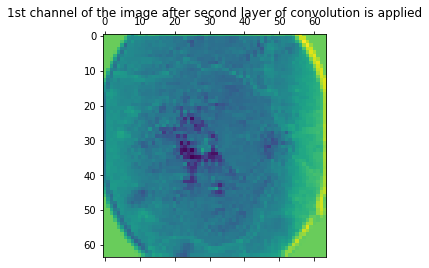

In [25]:
plt.matshow(activations[1][0, :, :,1 ], cmap ='viridis')
plt.title("1st channel of the image after second layer of convolution is applied")
plt.show()

## Function to display feature map of the activations layer

In [26]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='viridis')
            activation_index += 1

## Function to display feature map of the first activation layer : batch_normalization

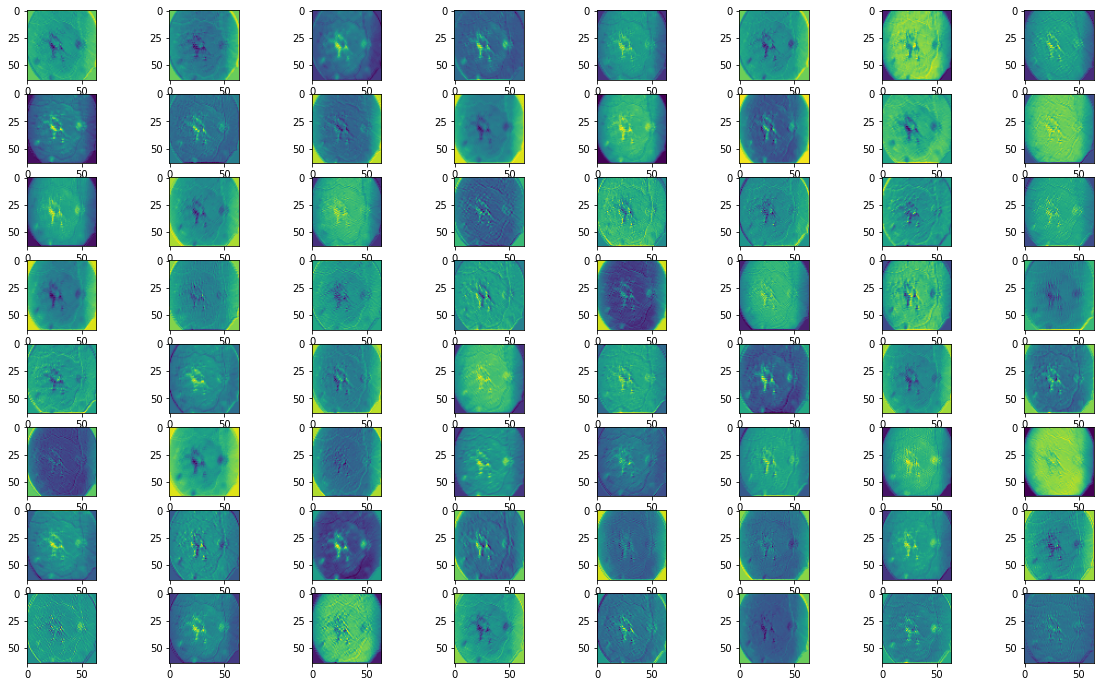

In [29]:
display_activation(activations, 8, 8, 1)

Feature maps of Layer 1 : conv2d 

Feature maps of Layer 2 : batch_normalization 

Feature maps of Layer 3 : activation 

Feature maps of Layer 4 : max_pooling2d 

Feature maps of Layer 5 : dropout 

Feature maps of Layer 6 : conv2d_1 

Feature maps of Layer 7 : batch_normalization_1 

Feature maps of Layer 8 : activation_1 



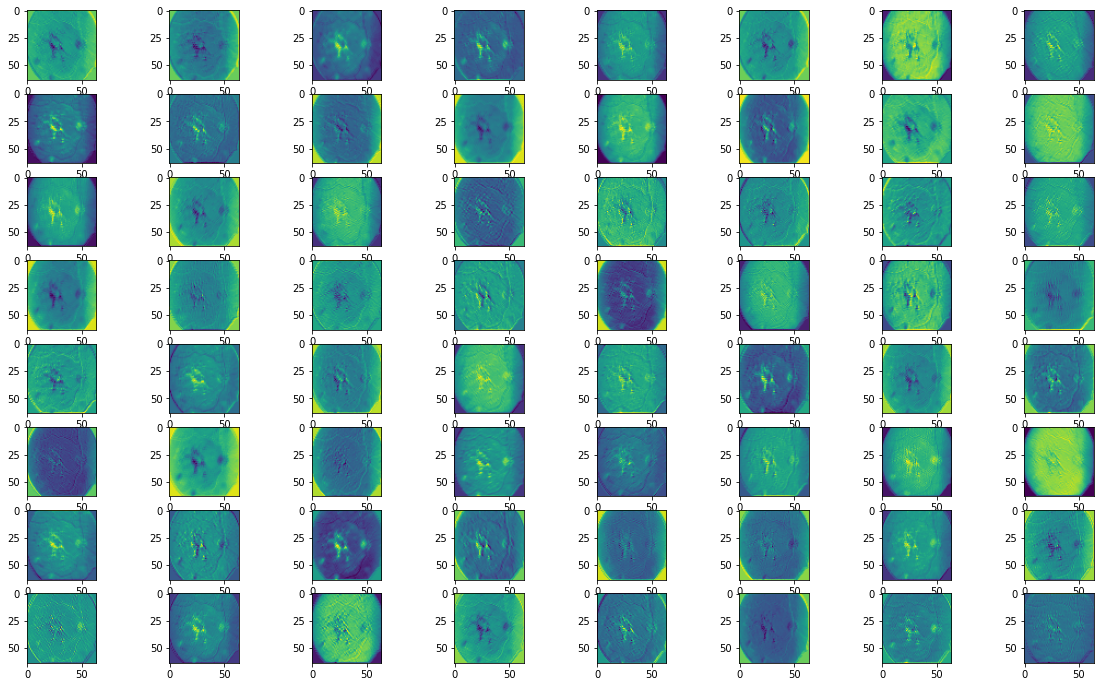

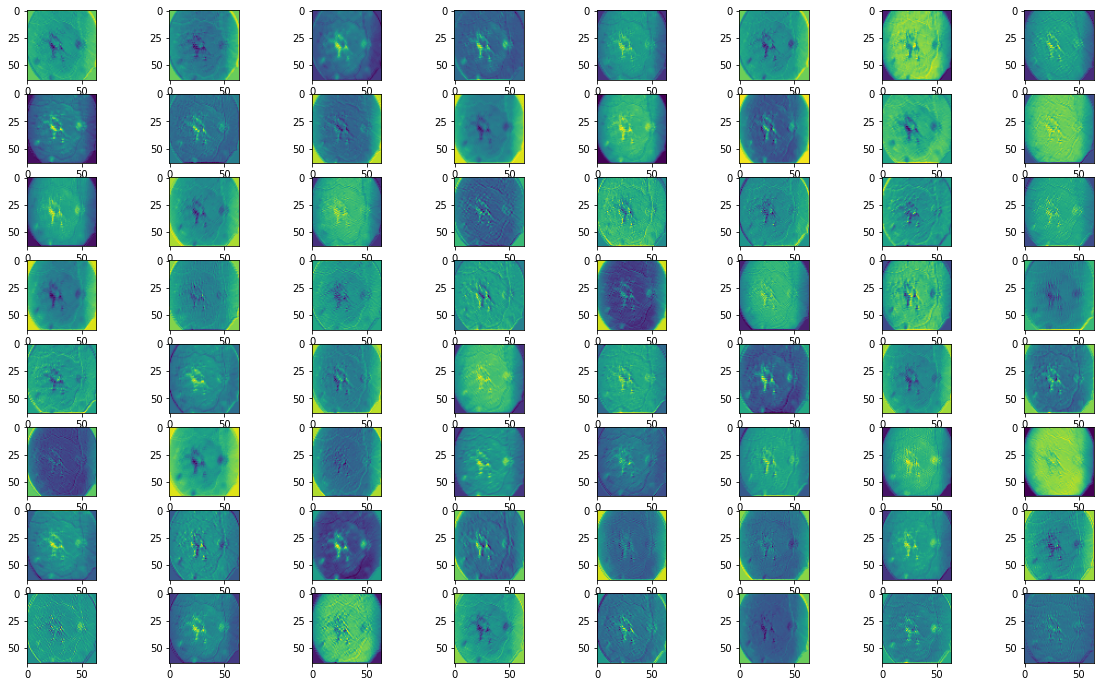

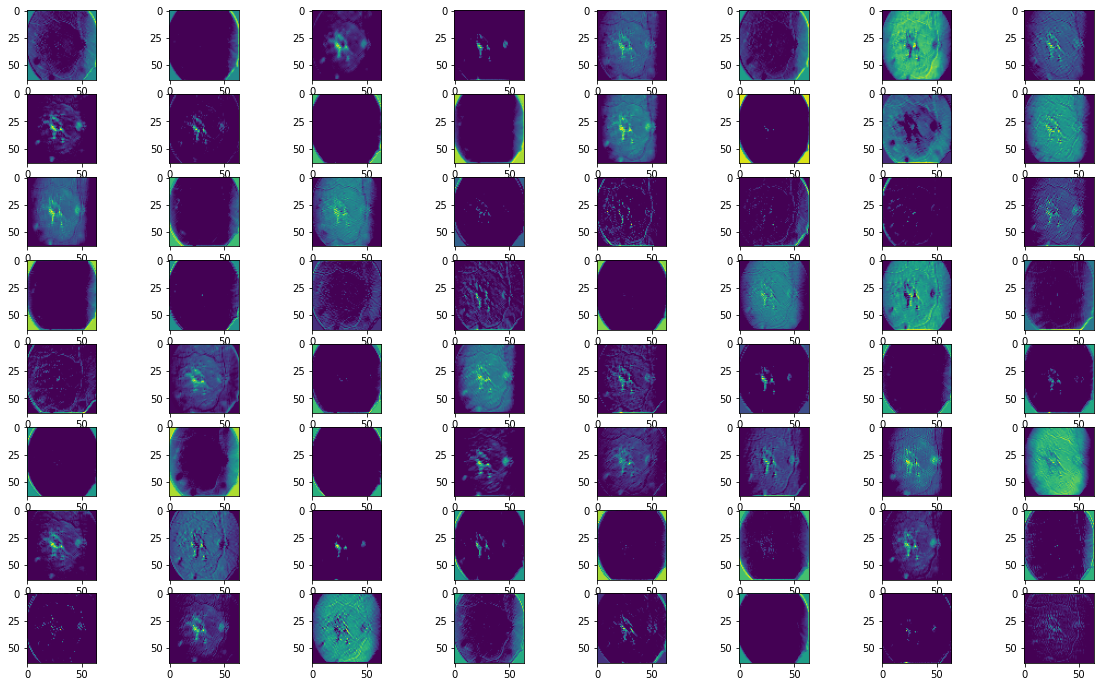

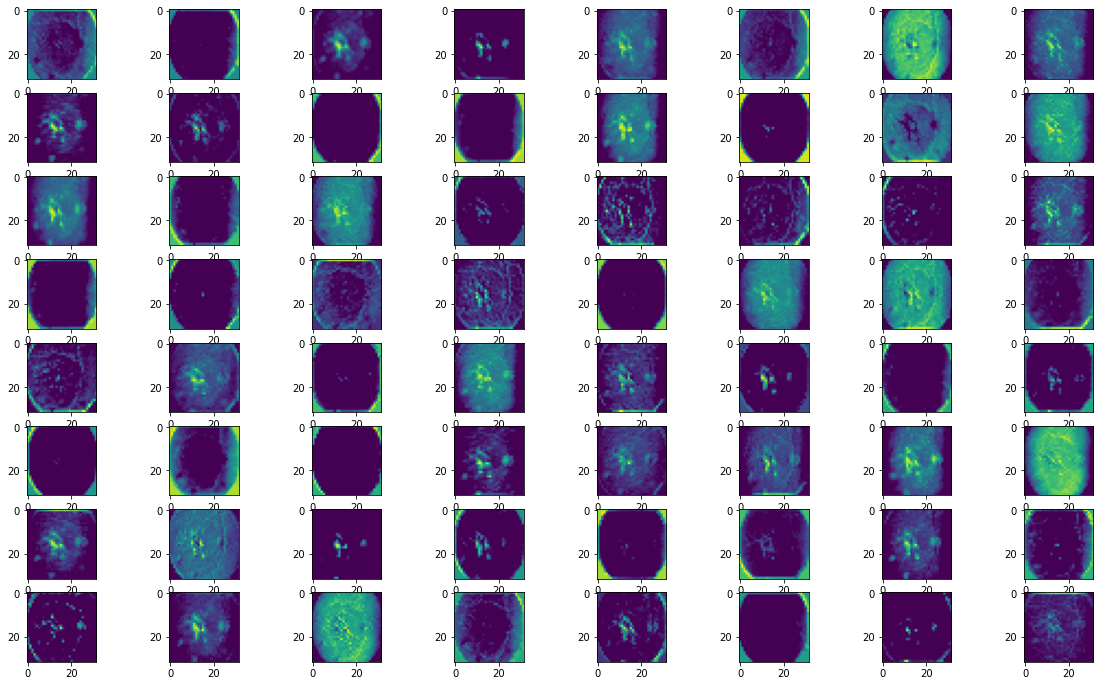

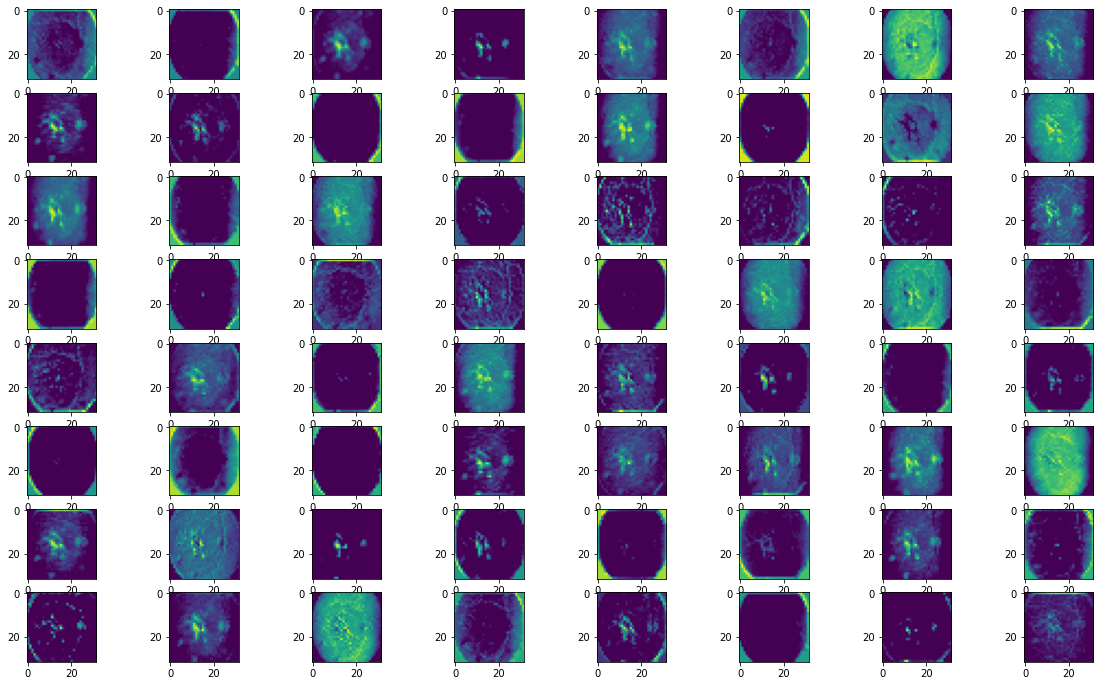

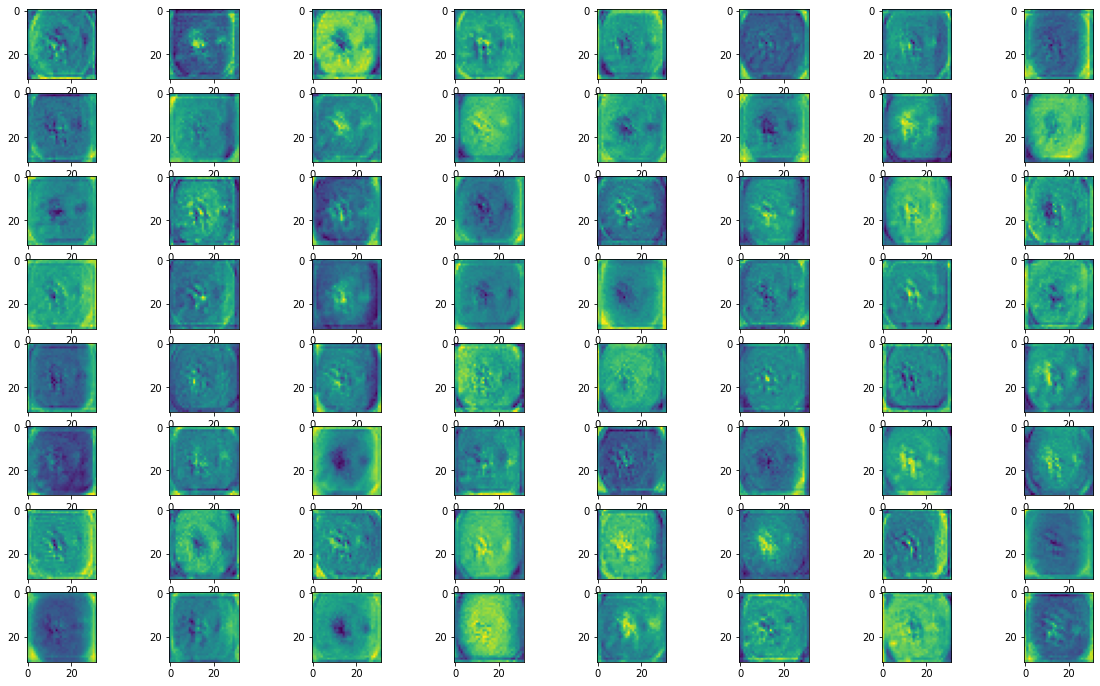

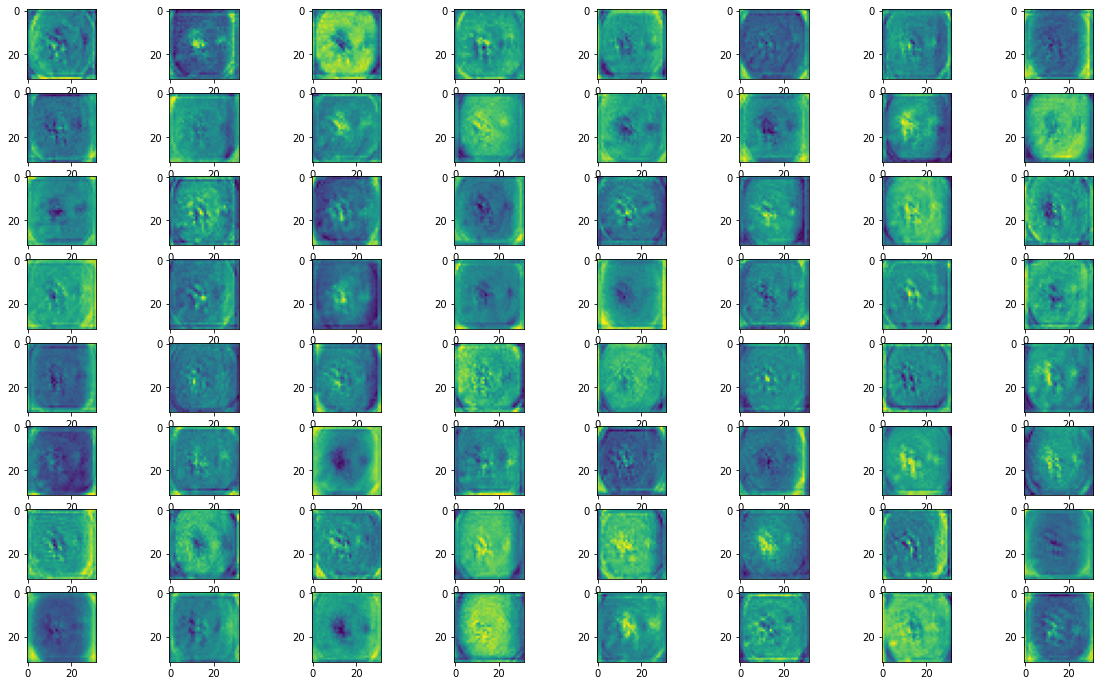

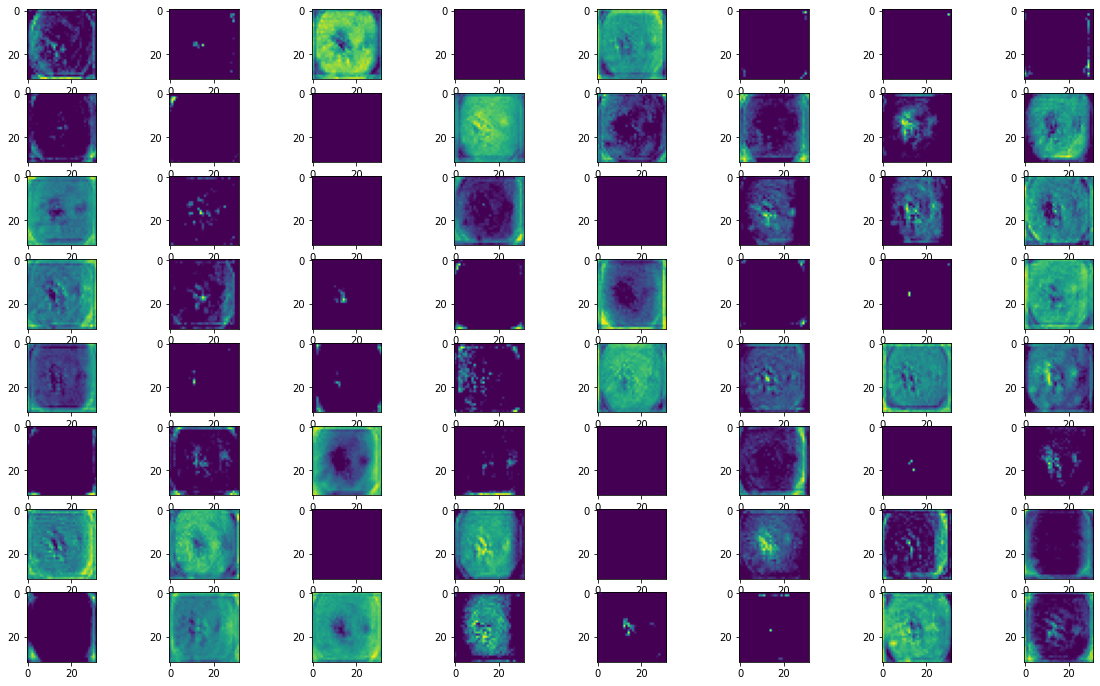

In [30]:
for i in range(8):
  print(f"Feature maps of Layer {i+1} : {layer_names[i]} \n")
  display_activation(activations,8,8, i)